# Power output for REZ for different energy scenarios

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# client.close()
# cluster.close()

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = "00:30:00"
cores = 24
memory = str(4 * cores) + "GB"

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=["-q normal",
                                           "-P dt6",
                                           "-l ncpus="+str(cores),
                                           "-l mem="+str(memory),
                                           "-l storage=gdata/w42+gdata/rt52+scratch/dt6"],
                     local_directory="$TMPDIR",
                     job_directives_skip=["select"])

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41735 instead
  warnings.warn(


In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.6.121.5:39295' processes=0 threads=0, memory=0 B>

In [5]:
import xarray as xr
import pandas as pd

In [6]:
%cd /g/data/w42/dr6273/work/power_models
import functions as fn

/g/data/w42/dr6273/work/power_models


In [7]:
%load_ext autoreload
%autoreload 2

# Load REZ data

#### REZ mask

In [8]:
mask = xr.open_dataset('/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_2024_mask_era5_grid.nc').REZ

#### REZ generation

In [18]:
_gen = pd.read_csv("/g/data/w42/dr6273/work/data/REZ/2024/REZ_potential.csv", index_col=0)

In [19]:
# Tidy column names
_gen.columns = [i.replace("90", "9-") for i in _gen.columns]
_gen.columns = [i.replace(" ", "_") for i in _gen.columns]

In [20]:
# Sum scenarios with existing capacity
gen = _gen.copy()
for col in _gen.columns[2:]:
    if col[:3] == "Exi":
        pass
    else:
        gen_type = col.split("_")[-2]
        gen[col] = _gen[col] + _gen["Existing_" + gen_type]

Set some REZs to zero wind. In the ISP, they have no modelled transmission, and/or in the IASR Workbook there are no capacity factors because there is a resource limit of zero.

- N7 Tumut
- S5 Northern SA

In [21]:
gen.loc["N7", gen.columns[-10:]] = 0
gen.loc["S5", gen.columns[-10:]] = 0

### Artifically increase generation in some REZs

- Based on https://github.com/dougrichardson/seasonal_energy/blob/main/06_capacity_factors.ipynb
- Testing to see if adding capacity alters correlation of energy with climate modes

##### Wind

In [22]:
# Replace Step change 2049-50 wind in N10 with 5,200 MW (https://www.dcceew.gov.au/energy/renewable/offshore-wind/areas/hunter)
gen["artificial_N10_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["N10", "artificial_N10_wind_2049-50"] = 5200

In [23]:
# Replace Step change 2049-50 wind in Q1 with green energy scenario
gen["artificial_Q1_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["Q1", "artificial_Q1_wind_2049-50"] = gen.loc["Q1"]["Green_energy_wind_2049-50"].copy()

In [24]:
# Replace Step change 2049-50 wind in Q2 with green energy scenario
gen["artificial_Q2_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["Q2", "artificial_Q2_wind_2049-50"] = gen.loc["Q2"]["Green_energy_wind_2049-50"].copy()

In [25]:
# Replace Step change 2049-50 wind in Q5 with green energy scenario
gen["artificial_Q5_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["Q5", "artificial_Q5_wind_2049-50"] = gen.loc["Q5"]["Green_energy_wind_2049-50"].copy()

In [26]:
# Replace Step change 2049-50 wind in Q6 with green energy scenario
gen["artificial_Q6_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["Q6", "artificial_Q6_wind_2049-50"] = gen.loc["Q6"]["Green_energy_wind_2049-50"].copy()

In [27]:
# Replace Step change 2049-50 wind in T3 with green energy scenario
gen["artificial_T3_wind_2049-50"] = gen["Step_change_wind_2049-50"].copy()
gen.loc["T3", "artificial_T3_wind_2049-50"] = gen.loc["T3"]["Green_energy_wind_2049-50"].copy()

##### Solar

In [28]:
# Replace Step change 2049-50 solar in V5 with green energy scenario
gen["artificial_V5_solar_2049-50"] = gen["Step_change_solar_2049-50"].copy()
gen.loc["V5", "artificial_V5_solar_2049-50"] = gen.loc["V5"]["Green_energy_solar_2049-50"].copy()

In [29]:
gen.tail()

Solar_renewable_potential_(MW)  Wind_renewable_potential_(MW)  \
REZ                                                                  
V4                                0                           3442   
V5                              500                           2000   
V6                             1700                           1600   
V7                                0                          54996   
V8                                0                           3330   

     Existing_solar  Progressive_solar_2029-30  Progressive_solar_2039-40  \
REZ                                                                         
V4                0                          0                          0   
V5              160                        160                        160   
V6              548                        548                        548   
V7                0                          0                          0   
V8                0                          0                          0   

     Progressive_solar_2049-50  Step_change_solar_2029-30  \
REZ                                                         
V4                           0                          0   
V5                         160                        160   
V6                         548                        548   
V7                           0                          0   
V8                           0                          0   

     Step_change_solar_2039-40  Step_change_solar_2049-50  \
REZ                                                         
V4                           0                          0   
V5                         160                        510   
V6                         548                       1948   
V7                           0                          0   
V8                           0                          0   

     Green_energy_solar_2029-30  ...  Green_energy_wind_2029-30  \
REZ                              ...                              
V4                            0  ...                       5350   
V5                         2810  ...                       5100   
V6                         1598  ...                       1200   
V7                            0  ...                          0   
V8                            0  ...                          0   

     Green_energy_wind_2039-40  Green_energy_wind_2049-50  \
REZ                                                         
V4                        5400                       7800   
V5                        5100                       5100   
V6                        1200                       1200   
V7                        8200                       8200   
V8                         780                        780   

     artificial_N10_wind_2049-50  artificial_Q1_wind_2049-50  \
REZ                                                            
V4                          6350                        6350   
V5                          2000                        2000   
V6                             0                           0   
V7                          8200                        8200   
V8                           780                         780   

     artificial_Q2_wind_2049-50  artificial_Q5_wind_2049-50  \
REZ                                                           
V4                         6350                        6350   
V5                         2000                        2000   
V6                            0                           0   
V7                         8200                        8200   
V8                          780                         780   

     artificial_Q6_wind_2049-50  artificial_T3_wind_2049-50  \
REZ                                                           
V4                         6350                        6350   
V5                         2000                        2000   
V6                            0                           0   
V7            

### Pre-compute capacity factor averages:

In [15]:
# def calculate_mean_cf(years, gen_type, method="van_der_Wiel", chunks=None):
#     """
#     Return mean capacity factor over all years
    
#     gen_type: str, 'wind' or 'solar'
#     method: str, method used to compute capacity factor, e.g. 'van_der_Wiel'
#     chunks: dict, how to chunk. Default is None
#     """
#     da_list = []
#     for year in years:
#         cf = fn.load_hourly_cf(year, gen_type, method=method, chunks={"lat": 75, "lon": 100, "time": -1}).capacity_factor
#         cf = cf.mean("time").expand_dims({"time": [year]})
#         da_list.append(cf)
#     cf = xr.concat(da_list, dim="time")
#     return cf.mean("time")

In [30]:
fp = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/"

In [37]:
# years = range(1940, 2024)

In [38]:
# compute = False

In [39]:
# if compute:
#     for gen_type in ["wind", "solar"]:
#         mean_cf = calculate_mean_cf(years, gen_type)
#         mean_cf.to_dataset(name="capacity_factor").to_netcdf(
#             fp + gen_type + "_mean_capacity_factor_van_der_Wiel_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc"
#         )
#         # mean_cf_2011_23 = calculate_mean_cf(range(2011, 2024), gen_type)
#         # mean_cf_2011_23.to_dataset(name="capacity_factor").to_netcdf(
#         #     fp + gen_type + "_mean_capacity_factor_2011_2023_van_der_Wiel_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc"
#         # )

### Load pre-computed capacity factor biases

In [40]:
# bias_dict = {}
# for scenario in ["Existing_wind", "Existing_solar"]:
#     bias_dict[scenario] = xr.open_mfdataset(
#         fp + scenario + "_multiplicative_bias_202012-202311.nc"
#     ).bias

# Compute generation

In [41]:
# def get_even_capacity_mask(mask_da, generation):
#     """
#     Return DataArray with mask of capacity divided evenly across grid cells
    
#     mask_da: array of REZ mask
#     generation: pandas Series of capacity values for each region (index).
#     """
#     da_list = []
#     for r in generation.index:
#         capacity = generation.loc[r]
#         n_cells = mask_da.sel(region=r).sum().values
        
#         da = mask_da.sel(region=r).where(
#             mask_da.sel(region=r) == 0,
#             capacity / n_cells
#         ).expand_dims({"REZ": [r]})
        
#         da_list.append(da)
        
#     return xr.concat(da_list, dim="REZ")

In [42]:
# def get_cf_scaled_capacity_mask(cf_mean, mask_da, generation):
#     """
#     Return DataArray with mask of capacity divided according to weights from average capacity factor
    
#     cf_mean: array of capacity factor weights
#     mask_da: array of REZ mask
#     generation: pandas Series of capacity values for each region (index).
#     """
#     da_list = []
#     for r in generation.index:
#         capacity = generation.loc[r]
        
#         cf_region = cf_mean.where(
#             mask_da.sel(region=r) == 1,
#             drop=True
#         )
#         weights = cf_region / cf_region.sum()
        
#         tolerance = 0.01
#         if 1 - weights.sum().values > tolerance:
#             print(weights.sum().values)
#             raise ValueError("Weights don't sum to one.")
            
#         da = (weights * capacity).expand_dims({"REZ": [r]})
        
#         da_list.append(da)
        
#     return xr.concat(da_list, dim="REZ")

In [31]:
def get_cf_scaled_capacity_mask(cf_mean, region, capacity):
    """
    Return DataArray with mask of capacity divided according to weights from average capacity factor
    
    cf_mean: array of capacity factor weights
    region: str, name of region e.g. Q1
    generation: int, capacity value
    """        
    weights = cf_mean / cf_mean.sum()

    # tolerance = 0.01
    # if 1 - weights.sum().values > tolerance:
    #     print(weights.sum().values)
    #     raise ValueError("Weights don't sum to one.")

    da = (weights * capacity).expand_dims({"region": [region]})        
    return da

In [46]:
# def calc_generation(capacity_factor, generation_capacity, capacity_factor_scaling=None):
#     """
#     Return DataArray with time series of power for each REZ
    
#     capacity_factor: DataArray of capacity factors
#     generation_capacity: DataArray of each grid cells generation capacity
#     capacity_factor_scaling: DataArray of scale factors for capacity factor
#     """
#     da_list = []
#     for r in generation_capacity.REZ.values:
#         r_mask = generation_capacity.sel(REZ=r).where(
#             generation_capacity.sel(REZ=r) > 0, drop=True
#         )
        
#         # Apply monthly bias correction if desired
#         if capacity_factor_scaling is not None:
#             if r[:1] == "N":
#                 region_scalings = capacity_factor_scaling.sel(region="NSW")
#             elif r[:1] == "Q":
#                 region_scalings = capacity_factor_scaling.sel(region="QLD")
#             elif r[:1] == "V":
#                 region_scalings = capacity_factor_scaling.sel(region="VIC")
#             elif r[:1] == "S":
#                 region_scalings = capacity_factor_scaling.sel(region="SA")
#             elif r[:1] == "T":
#                 region_scalings = capacity_factor_scaling.sel(region="TAS")
#             else:
#                 raise ValueError("Incorrect r")
            
#             capacity_factor_scaled = capacity_factor.groupby("time.month") * region_scalings
#             da = capacity_factor_scaled * r_mask
#         else:
#             # Or use raw data
#             da = capacity_factor * r_mask
            
#         da = da.sum(["lat", "lon"])
#         da = da.expand_dims({"REZ": [r]})

#         da_list.append(da)

#     return xr.concat(da_list, dim="REZ")

In [32]:
def calc_all_years_generation(filename, years, mask_da, generation, cf_type, capacity_factor_scaling=None, scale_mask="capacity_factor", method="van_der_Wiel", add_dir=""):
    """
    Compute power time series for each REZ and each year.
    
    filename: str, initial text as part of saved filename
    years: range
    mask_da: array, mask of REZs
    generation: pandas Series with index as REZ ID and values as generation capacity
    cf_type: str, 'wind_medium', 'wind_high' or 'solarpv'
    capacity_factor_scaling: array with month and region dimensions, default None
    scale_mask: str, 'capacity_factor' to scale by mean capacity factors,
        'even' for an even distribution of generation amongst REZ cells,
        'none' to use mask_da directly.
    method: str, which method of capacity factors was used
    add_dir, add_dir: str, additional directory for load_hourly_cf, default ""
    """
    def _get_gen_type(gen):
        g_split = gen.name.split("_")
        if g_split[0] == "Solar":
            gt = "solar"
        elif g_split[0] == "Wind":
            gt = "wind"
        elif g_split[0] == "Existing":
            gt = g_split[1]
        else:
            gt = g_split[-2]
        return gt
    
    gen_type = _get_gen_type(generation)
    cf_path = "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + gen_type + "/capacity_factor/" + method + "/bias_corrected/"
    
#     if capacity_factor_scaling is not None:
#         cf_scaling = capacity_factor_scaling["Existing_"+gen_type]
#     else:
#         cf_scaling = None
    
#     if scale_mask == "capacity_factor": # Use mean capacity factor weights to split the generation capacities by
#         mean_cf = xr.open_dataset(
#             "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/" + \
#             gen_type + "_mean_capacity_factor_van_der_Wiel_era5_hourly_1940-2023.nc"
#         )["capacity_factor"]
        
#         gen_capacity = get_cf_scaled_capacity_mask(mean_cf, mask_da, generation)
        
#     elif scale_mask == "even": # Divide the generation capacity by the size of the region and assign each cell that number
#         gen_capacity = get_even_capacity_mask(mask_da, generation)
        
#     else: # Just use mask_da as the generation capacities for each cell
#         gen_capacity = mask_da.copy()
    
    # Drop regions with zero generation
    regions = generation.drop(generation[generation == 0].index)
    
    da_list = []
    for region, capacity in zip(regions.index, regions):
        # print(region, capacity)
        
        # Generation capacity for region r
        # r_mask = gen_capacity.sel(REZ=r).where(
        #     gen_capacity.sel(REZ=r) > 0, drop=True
        # )
        
        # Load bias-corrected capacity factors
        # print(cf_path + cf_type + "_capacity_factor_" + method + "_era5_hourly_1940-2023_" + region + ".nc")
        cf_r_bc = xr.open_mfdataset(
            cf_path + cf_type + "_capacity_factor_" + method + "_era5_hourly_1940-2023_" + region + ".nc",
        ).capacity_factor

        # Generation capacity for region r
        cf_mask = cf_r_bc.mean("time")
        gen_capacity = get_cf_scaled_capacity_mask(cf_mask, region, capacity)
        # return gen_capacity

        # Compute power
        power = cf_r_bc * gen_capacity
        power = power.sum(["lat", "lon"])
        power = power.rename("power")
        # power = power.expand_dims({"region": [region]})

        da_list.append(power)
        
    REZ_power = xr.concat(da_list, dim="region")
    REZ_power = REZ_power.chunk({"region": -1, "time": -1})
    return REZ_power



#     for year in years:
#         cf = fn.load_hourly_cf(year, gen_type, method=method, add_dir=add_dir, chunks={"lat": -1, "lon": -1, "time": 2500}).capacity_factor
#         p = calc_generation(cf, gen_capacity, capacity_factor_scaling=cf_scaling)
# #         da_list.append(p)
# #     REZ_power = xr.concat(da_list, dim="time")
# #     REZ_power = REZ_power.chunk({"REZ": -1, "time": -1})
    
# #     return REZ_power
#         p.drop_vars("month").to_dataset(name="power").to_netcdf(
#             "/scratch/dt6/dr6273/data/energy/yearly/" + filename + "_" + generation.name + "_van_der_Wiel" + "_era5_hourly_" + str(year) + ".nc",
#             mode="w"
#         )

In [33]:
years = range(1940, 2024)

In [51]:
scenarios = [gen.columns[-2]]
scenarios

['artificial_T3_wind_2049-50']

In [52]:
scenarios = list(scenarios) * 2
scenarios

['artificial_T3_wind_2049-50', 'artificial_T3_wind_2049-50']

In [53]:
# cf_type_list = ["solarpv" for _ in range(4)] + ["wind_medium" for _ in range(4)] + ["wind_high" for _ in range(4)]
cf_type_list = ["wind_medium" for _ in range(1)] + ["wind_high" for _ in range(1)]# + ["solarpv"]
cf_type_list

['wind_medium', 'wind_high']

In [54]:
%%time
# for scenario in gen.columns[[2, 6, 7, 8, 12, 16, 17, 18]]:
for (scenario, cf_type) in zip(scenarios, cf_type_list):
    print(scenario, cf_type)
    
    gen_ds = calc_all_years_generation("REZ_power", None, mask, gen[scenario], cf_type)
    
    # bias_dict being computed means a frustrating repeated computation
    #  But if bias_dict is lazily loaded, there is not enough memory and we would likely need to process each year separately
#     gen_ds = calc_all_years_generation(years, mask, gen[scenario], capacity_factor_scaling=bias_dict)
#     gen_ds = gen_ds.to_dataset(name="power")
    
#     # Tidy path to write
#     if scenario.split("_")[-1] == "(MW)":
#         scenario = scenario[:-5]
#     scenario = scenario.lower()
    
    gen_ds.to_netcdf(
        "/scratch/dt6/dr6273/data/energy/" + "REZ_power_" + cf_type + "_" + scenario + "_van_der_Wiel" + "_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc",
        mode="w"
    )

    # Too much memory needed to do it the previous way (when bias correcting capacity factors was not needed)
    #  So we process year by year
    # calc_all_years_generation("REZ_power", years, mask, gen[scenario], capacity_factor_scaling=bias_dict)

artificial_T3_wind_2049-50 wind_medium
artificial_T3_wind_2049-50 wind_high
CPU times: user 6.63 s, sys: 4.52 s, total: 11.2 s
Wall time: 19.2 s


### Check results

Load ISP data from OpenElectricity

In [14]:
isp_capacity = pd.read_csv(
    "NEM-aemo2024-step_change-CDP14-capacity.csv",
    index_col=0,
    parse_dates=True,
    usecols=[0,7,8],
    na_values="—"
)

/jobfs/146573383.gadi-pbs/ipykernel_1370654/1036585230.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  isp_capacity = pd.read_csv(


In [15]:
isp_energy = pd.read_csv(
    "NEM-aemo2024-step_change-CDP14-energy.csv",
    index_col=0,
    parse_dates=True,
    usecols=[0,7,8],
    na_values="—"
)

/jobfs/146573383.gadi-pbs/ipykernel_1370654/379260345.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  isp_energy = pd.read_csv(


In [20]:
gen_dict = {}
for (scenario, cf_type) in zip(scenarios, cf_type_list):
    print(scenario, cf_type)
    da = xr.open_mfdataset(
        "/scratch/dt6/dr6273/data/energy/" + "REZ_power_" + cf_type + "_" + scenario + "_van_der_Wiel" + "_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc",
    )
    gen_dict[cf_type + "_" + scenario] = da.power.sum("region").resample(time="1YS").sum().compute() / 1e6

Existing_solar solarpv
Step_change_solar_2029-30 solarpv
Step_change_solar_2039-40 solarpv
Step_change_solar_2049-50 solarpv
Existing_wind wind_medium
Step_change_wind_2029-30 wind_medium
Step_change_wind_2039-40 wind_medium
Step_change_wind_2049-50 wind_medium
Existing_wind wind_high
Step_change_wind_2029-30 wind_high
Step_change_wind_2039-40 wind_high
Step_change_wind_2049-50 wind_high


In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
ix = pd.date_range(start=isp_energy.index[0], end=isp_energy.index[-1], freq='MS')
isp_energy = isp_energy.reindex(ix)
isp_energy = isp_energy.interpolate(axis=0)

In [23]:
# ix = pd.date_range(start=isp_capacity.index[0], end=isp_capacity.index[-1], freq='MS')
# isp_capacity = isp_capacity.reindex(ix)
# isp_capacity = isp_capacity.interpolate(axis=0)

In [24]:
def plot_model_lines(ax, da_list, isp_arr, x, color, ls, label):
    """
    Plot horizontal and vertical lines that indicate modelled values.
    
    ax: axes
    da_list: list of DataArrays of model data
    isp_arr: array, isp time series
    x: array, x-axis data
    color: str
    ls: str
    label: str
    """
    model = [da.sel(time=slice("2011", "2023")).mean("time") for da in da_list]
    model_mean = np.mean(model)
    
    ix = np.searchsorted(isp_arr, model_mean)
    
    color="k"
    
    if ix >= isp_arr.index.shape[0]:
        ax.plot((x[0], x[-1]), (model_mean, model_mean), color=color, ls=ls, label=label)
    else:
        ax.plot(
            (x[0], x[ix]),
            (model_mean, model_mean),
            color=color, ls=ls, label=label
        )
        ax.plot(
            (x[ix], x[ix]),
            (0, model_mean),
            color=color, ls=ls
        )

In [46]:
def capacity_diff(isp_key, isp_year, gen_key):
    """
    Modelled capacity minus ISP capacity for a given year
    """
    m = gen[gen_key].sum() / 1e3
    i = isp_capacity[isp_key].loc[isp_year].values[0]
    rounded = [int(np.round(x, 0)) for x in [m, i, m - i]]
    return [isp_year] + rounded

In [55]:
def str_cap_diff(cap):
    """
    String of capacities for figure
    
    cap: list of capacities for model, ISP and model minus ISP
    """
    # return cap[0]+" Model: "+str(cap[1])+", ISP: "+str(cap[2])+", Diff: "+str(cap[3])+" [GW]"
    return cap[0]+" Model: "+str(cap[1])+", ISP: "+str(cap[2])+" [GW]"

In [48]:
str_cap_diff(
    capacity_diff("Wind", "2050", "Step_change_wind_2049-50")
)

'2050 Model: 75, ISP: 69, Diff: 6 [GW]'

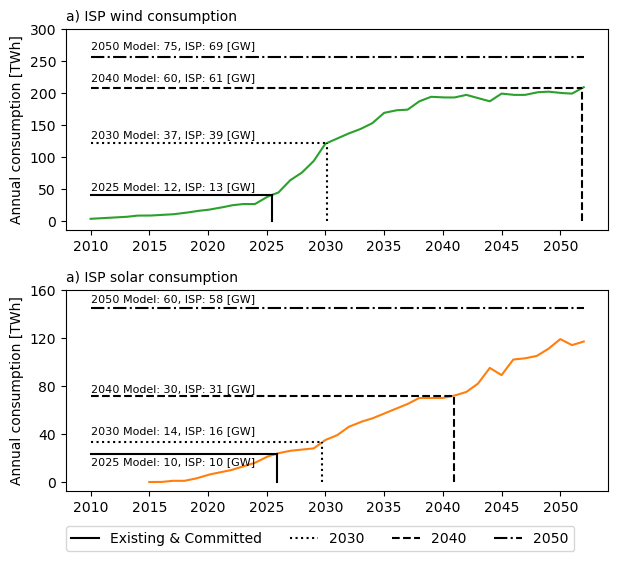

In [61]:
fig, ax = plt.subplots(2, 1, figsize=(7, 6))

x = isp_energy["Wind"].index

# ISP time series
ax[0].plot(x, isp_energy["Wind"], color="tab:green")
ax[1].plot(x, isp_energy["Solar (Utility)"], color="tab:orange")

# Model 2011-2023 averages
plot_model_lines(
    ax[0],
    [gen_dict["wind_medium_Existing_wind"], gen_dict["wind_high_Existing_wind"]],
    isp_energy["Wind"],
    isp_energy.index,
    "tab:green",
    "-",
    "Existing & Committed"
)
plot_model_lines(
    ax[0],
    [gen_dict["wind_medium_Step_change_wind_2029-30"], gen_dict["wind_high_Step_change_wind_2029-30"]],
    isp_energy["Wind"],
    isp_energy.index,
    "tab:green",
    ":",
    "2030"
)
plot_model_lines(
    ax[0],
    [gen_dict["wind_medium_Step_change_wind_2039-40"], gen_dict["wind_high_Step_change_wind_2039-40"]],
    isp_energy["Wind"],
    isp_energy.index,
    "tab:green",
    "--",
    "2040"
)
plot_model_lines(
    ax[0],
    [gen_dict["wind_medium_Step_change_wind_2049-50"], gen_dict["wind_high_Step_change_wind_2049-50"]],
    isp_energy["Wind"],
    isp_energy.index,
    "tab:green",
    "-.",
    "2050"
)

plot_model_lines(
    ax[1],
    [gen_dict["solarpv_Existing_solar"]],
    isp_energy["Solar (Utility)"],
    isp_energy.index,
    "tab:orange",
    "-",
    "Existing & Committed"
)
plot_model_lines(
    ax[1],
    [gen_dict["solarpv_Step_change_solar_2029-30"]],
    isp_energy["Solar (Utility)"],
    isp_energy.index,
    "tab:orange",
    ":",
    "2030"
)
plot_model_lines(
    ax[1],
    [gen_dict["solarpv_Step_change_solar_2039-40"]],
    isp_energy["Solar (Utility)"],
    isp_energy.index,
    "tab:orange",
    "--",
    "2040"
)
plot_model_lines(
    ax[1],
    [gen_dict["solarpv_Step_change_solar_2049-50"]],
    isp_energy["Solar (Utility)"],
    isp_energy.index,
    "tab:orange",
    "-.",
    "2050"
)

for (y, year, scenario) in zip(
    [50, 130, 220, 270],
    ["2025", "2030", "2040", "2050"],
    ["Existing_wind", "Step_change_wind_2029-30", "Step_change_wind_2039-40", "Step_change_wind_2049-50"]
):
    ax[0].text(
        isp_energy.index[0],
        y,
        str_cap_diff(
            capacity_diff("Wind", year, scenario)
        ),
        fontsize=8
    )
    
for (y, year, scenario) in zip(
    [15, 40, 75, 150],
    ["2025", "2030", "2040", "2050"],
    ["Existing_solar", "Step_change_solar_2029-30", "Step_change_solar_2039-40", "Step_change_solar_2049-50"]
):
    ax[1].text(
        isp_energy.index[0],
        y,
        str_cap_diff(
            capacity_diff("Solar (Utility)", year, scenario)
        ),
        fontsize=8
    )
    
ax[0].set_yticks(range(0, 301, 50))
ax[1].set_yticks(range(0, 161, 40))

ax[0].set_title("a) ISP wind consumption", fontsize=10, loc="left")
ax[1].set_title("a) ISP solar consumption", fontsize=10, loc="left")

for a in ax:
    a.set_ylabel("Annual consumption [TWh]")
    

ax[1].legend(ncols=4, loc=(0, -0.3))

plt.subplots_adjust(hspace=0.3)

In [37]:
gen["Existing_wind"].sum()/1e3

12.105

In [55]:
gen["Step_change_wind_2039-40"].sum()

60385

In [56]:
gen["Step_change_wind_2049-50"].sum()

75285

(0.0, 300.0)

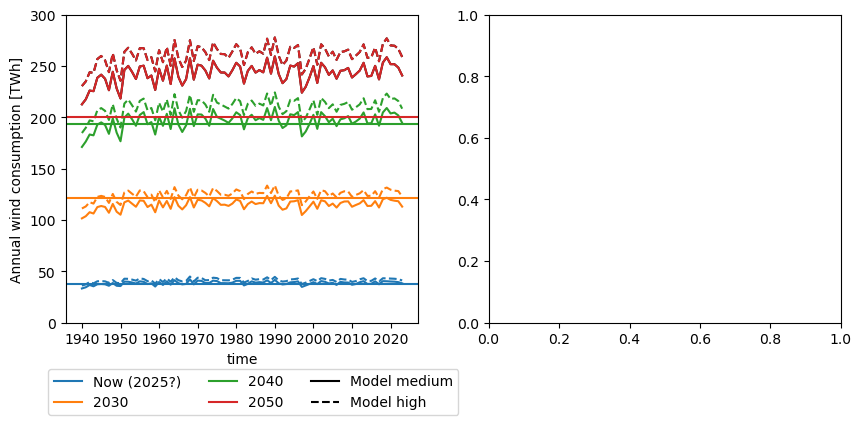

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

gen_dict["wind_medium_Existing_wind"].plot(ax=ax[0], color="tab:blue", ls="-")
gen_dict["wind_high_Existing_wind"].plot(ax=ax[0], color="tab:blue", ls="--")
ax[0].axhline(38, color="tab:blue", ls="-", label="Now (2025?)")

gen_dict["wind_medium_Step_change_wind_2029-30"].plot(ax=ax[0], color="tab:orange", ls="-")
gen_dict["wind_high_Step_change_wind_2029-30"].plot(ax=ax[0], color="tab:orange", ls="--")
ax[0].axhline(121, color="tab:orange", ls="-", label="2030")

gen_dict["wind_medium_Step_change_wind_2039-40"].plot(ax=ax[0], color="tab:green", ls="-")
gen_dict["wind_high_Step_change_wind_2039-40"].plot(ax=ax[0], color="tab:green", ls="--")
ax[0].axhline(193, color="tab:green", ls="-", label="2040")

ax[0].axhline(200, color="tab:red", ls="-", label="2050")
gen_dict["wind_medium_Step_change_wind_2049-50"].plot(ax=ax[0], color="k", ls="-", label="Model medium")
gen_dict["wind_high_Step_change_wind_2049-50"].plot(ax=ax[0], color="k", ls="--", label="Model high")
gen_dict["wind_medium_Step_change_wind_2049-50"].plot(ax=ax[0], color="tab:red", ls="-")
gen_dict["wind_high_Step_change_wind_2049-50"].plot(ax=ax[0], color="tab:red", ls="--")




ax[0].legend(ncols=3, loc=(-0.05, -0.3))
ax[0].set_ylabel("Annual wind consumption [TWh]")
ax[0].set_ylim(0, 300)

In [67]:
gen["Step_change_solar_2039-40"].sum()

29843

In [68]:
gen["Step_change_solar_2049-50"].sum()

60343

(0.0, 180.0)

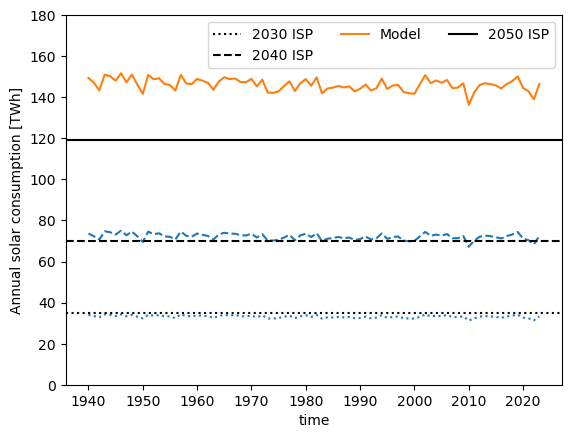

In [66]:
gen_dict["solarpv_Step_change_solar_2029-30"].plot(color="tab:blue", ls=":")
plt.axhline(35, color="k", ls=":", label="2030 ISP")

gen_dict["solarpv_Step_change_solar_2039-40"].plot(color="tab:blue", ls="--")
plt.axhline(70, color="k", ls="--", label="2040 ISP")

gen_dict["solarpv_Step_change_solar_2049-50"].plot(color="tab:blue", label="Model")
plt.axhline(119, color="k", ls="-", label="2050 ISP")

plt.legend(ncols=3)
plt.ylabel("Annual solar consumption [TWh]")
plt.ylim(0, 180)

### Repeat but for existing facilities in sites outside REZs

In [ ]:
solar_outside = xr.open_mfdataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/solar/power/solar_site_outside_REZ_mask_era5.nc",
).solar_site
# Change dimension name so it works with function
solar_outside = solar_outside.rename({"region": "REZ"}).compute()

In [ ]:
wind_outside = xr.open_mfdataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind/power/wind_site_outside_REZ_mask_era5.nc",
).wind_site
wind_outside = wind_outside.rename({"region": "REZ"}).compute()

In [ ]:
%%time
for scenario, m in zip(['Existing_solar', 'Existing_wind'], [solar_outside, wind_outside]):
    print(scenario)
#     gen_ds = calc_all_years_generation(years, m, gen[scenario], scale_mask="none")
#     gen_ds = gen_ds.to_dataset(name="power")
    
#     # Tidy path to write
#     if scenario.split("_")[-1] == "(MW)":
#         scenario = scenario[:-5]
#     scenario = scenario.lower()
    
#     gen_ds = gen_ds.rename({"REZ": "region"}) # Change dimension name back
    
#     gen_ds.to_netcdf(
#         fp + "site_outside_REZ_power_" + scenario + "_van_der_Wiel" + "_era5_hourly_" + str(years[0]) + "-" + str(years[-1]) + ".nc",
#         mode="w"
#     )
    calc_all_years_generation("site_outside_REZ_power", years, m, gen[scenario], capacity_factor_scaling=bias_dict, scale_mask="none")

# Close cluster

In [55]:
client.close()
cluster.close()